In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
import cycler
from matplotlib.lines import Line2D

In [2]:
project = signac.get_project("ptb7-project")

In [3]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)
def msd_slope(job, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job.fn('msd.log'), names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return x, y, slope

In [4]:
#constant density of msd.log
def msd_constant_density(density, temp_min, temp_max, polymer_length=None):
    state_dict = {"size": "small",
                  "process": "quench",
                  "density":density,
                  "molecule":"PTB7_{}mer_smiles"}
    if polymer_length:
        state_dict["molecule"] = "PTB7_{}mer_smiles".format(polymer_length)
    job_list = project.find_jobs(state_dict)
    slope_values = []
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in job_list:
        if temp_min <= job.sp['kT_reduced'] <= temp_max:
            x, y, slope = msd_slope(job)
            ax.plot(x, y, label=job.sp['kT_reduced'])
            slope_values.append(slope)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles,labels = ax.get_legend_handles_labels()
    as_float = [float(i) for i in labels]
    order = np.argsort(as_float)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles,labels,loc=2)
    plt.show()

#constant temperature of msd.log
def msd_constant_temperature(kT_reduced, den_min, den_max, polymer_length=None):
    state_dict = {"size": "small",
                  "process": "quench",
                  "kT_reduced":kT_reduced,
                  "molecule":"PTB7_{}mer_smiles"}
    if polymer_length:
        state_dict["molecule"] = "PTB7_{}mer_smiles".format(polymer_length)
    job_list = project.find_jobs(state_dict)
    slope_values = []
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in job_list:
        if den_min <= job.sp['density'] <= den_max:
            x, y, slope = msd_slope(job)
            ax.plot(x, y, label=job.sp['density'])
            slope_values.append(slope)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.title("MSD of PTB7 densities at %skT" % (job.sp['kT_reduced']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles,labels = ax.get_legend_handles_labels()
    as_float = [float(i) for i in labels]
    order = np.argsort(as_float)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles,labels,loc=2)
    plt.show()
    
def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

# MSD plots for msd.log files

#### constant density plot

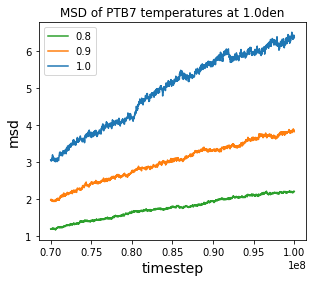

In [5]:
msd_constant_density(density=1.0,
                      polymer_length=5,
                      temp_min=0.8,
                      temp_max=1.0)

#### constant temperature plot

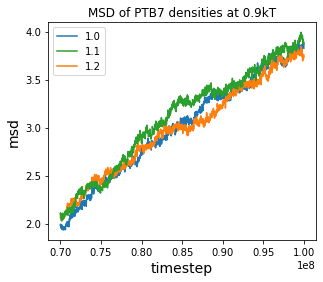

In [6]:
msd_constant_temperature(kT_reduced=0.9,
                      polymer_length=5,
                      den_min=1.0,
                      den_max=1.2)

# MSD plots for trajectory.gsd files

#### constant density

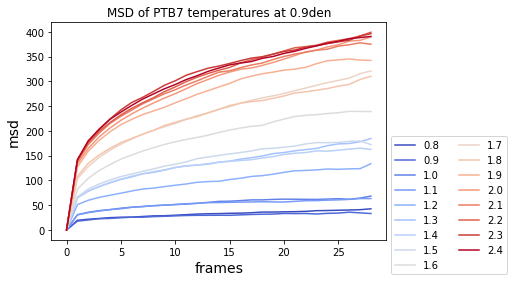

In [11]:
state_dict = {"size": "small",
             "density": 0.9,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}
state_dict['density.$lt'] = 1.3


job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
    y = msd
    tspf = job.sp['n_steps'] / 100
    x = range(len(y))
    plt.plot(x, y, label=kT)
plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
plt.xlabel("frames", fontsize=14)
plt.ylabel("msd", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

#### constant temperature

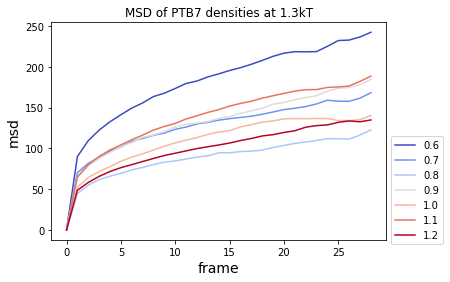

In [13]:
project = signac.get_project("ptb7-project")
state_dict = {"size": "small",
             "kT_reduced": 1.3,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}
state_dict['kT_reduced.$lt'] = 2.5


job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for den,job in job_list.groupby('density'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
    plt.plot(msd, label=den)

plt.title("MSD of PTB7 densities at %skT" % (job.sp['kT_reduced']))
plt.xlabel("frame", fontsize=14)
plt.ylabel("msd", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

### Slopes

#### saving slope as timesteps to job.doc

In [10]:
project = signac.get_project("ptb7-project")
state_dict = {'size': 'small', 'process': 'quench'}
job_list = project.find_jobs(state_dict)
for job in job_list:
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    y = msd[-15:]
    tspf = job.sp['n_steps'] / 100
    x = np.arange(0, len(y), 1) * tspf
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    job.doc['msd_slope'] = slope
    job.doc['msd_slope_r2'] = r_value

In [12]:
print(job.doc)

{'steps': 100000000.0, 'avogadro': 6.022140857e+23, 'boltzmann': 1.38064852e-23, 'kj_to_j': 1000.0, 'amu_to_kg': 1.6605e-27, 'nm_to_m': 1e-09, 'mass': 32.06, 'mass_units': 'amu', 'energy': 1.046, 'energy_units': 'kj/mol', 'distance': 0.35635948725613575, 'distance_units': 'nm', 'T_SI': 164.0, 'T_unit': 'K', 'real_timestep': 1.973, 'time_unit': 'fs', 'msd_slope': 2.28418667632443e-06, 'msd_slope_r2': 0.9905256545709946}


## Temp v Slope plots

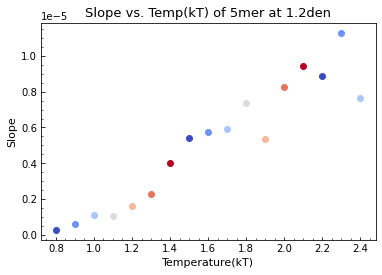

In [13]:
state_dict = {'size': 'small', 'process': 'quench', "density": 1.2, "molecule":"PTB7_5mer_smiles" }
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
state_dict['kT_reduced.$lt'] = 2.5
color = plt.cm.viridis(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for temp,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    plt.scatter(x2,y2, label=temp)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
plt.title("Slope vs. Temp(kT) of 5mer at %sden" % (job.sp['density']), fontsize=13 )
plt.xlabel("Temperature(kT)", fontsize=11)
plt.ylabel("Slope", fontsize=11)
plt.show()

#### slope vs. temp for multiple polymer lengths

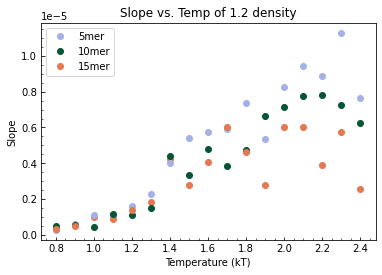

In [17]:
state_dict = {'size': 'small', 'process': 'quench', "density": 1.2}
job_list = project.find_jobs(state_dict)
for idx,job in enumerate(job_list):
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    if job.sp['molecule'] == "PTB7_5mer_smiles":
        col = ['#a4b1e7']
    if job.sp['molecule'] == "PTB7_10mer_smiles":
        col = ['#065535']
    if job.sp['molecule'] == "PTB7_15mer_smiles":
        col = ['#e4794f']
    plt.scatter(x2,y2, color = col)
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in')
plt.title('Slope vs. Temp of %s density' % (job.sp['density']))
plt.xlabel('Temperature (kT)')
plt.ylabel('Slope')
colors = ['#a4b1e7', '#065535', '#e4794f']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='None', marker= 'o') for c in colors]
labels = ['5mer', '10mer', '15mer']
plt.legend(lines, labels)
plt.show()

## msd direct mode (log/gsd comparison)

In [119]:
#changing msd_mode to "direct"
def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='all', msd_mode = "direct"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f) 
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:] 
        else:
            atom_positions = atom_type_pos(frame, atom_type) 
        positions.append(atom_positions) 
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd)
    return np.concatenate(positions)

#adjusting start times for msd.log
def msd_slope(job, step_size = -5000, atom_types='all'):  
    msd = np.genfromtxt(job.fn('msd.log'), names=True, delimiter="\t")
    x = msd['timestep'][-4925::step_size]
    y = msd[atom_types][-4925::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return x, y, slope

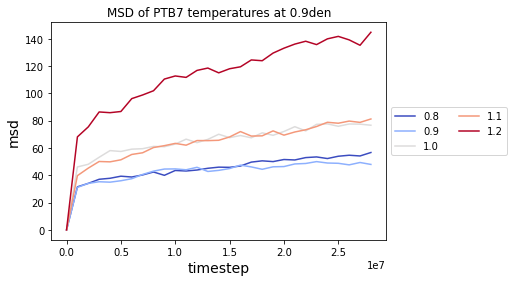

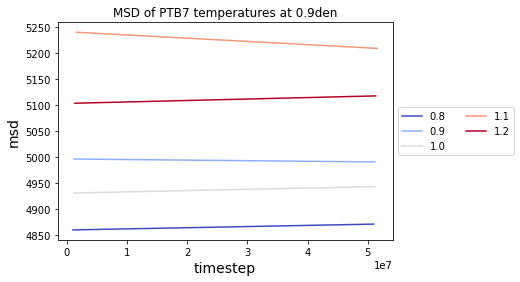

In [120]:
#msd constant density of trajectory.gsd
project = signac.get_project("ptb7-project")
state_dict = {"size": "small",
             "density": 0.9,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}
state_dict['density.$lt'] = 1.3
state_dict['kT_reduced.$lt'] = 1.3

job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
    y = msd
    tspf = job.sp['n_steps'] / 100
    x = np.arange(0, len(y), 1) * tspf
    plt.plot(x, y, label=kT)
plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
plt.xlabel("timestep", fontsize=14)
plt.ylabel("msd", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()


#msd constant density of msd.log
def msd_constant_density(density, polymer_length=None):
    state_dict = {"size": "small",
                  "process": "quench",
                  "density":0.9,
                  "molecule":"PTB7_5mer_smiles"}
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    x, y, slope = msd_slope(job)
    plt.plot(x,y, label=kT)
plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
plt.xlabel("timestep", fontsize=14)
plt.ylabel("msd", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

## Notes

In [15]:
'''OBSERVATIONS 

At 0.6den:
Lower temp = lower msd
1.3kT has significantly different(higher) MSD at 0.6den

At 0.7den:
Lower temp = lower msd
1.3kT and 1.2kT msds are very similar at 0.7den 

At 0.8den:
1.4kT MSD shows up at 0.8den, weird.
These plots are kind of all over the place. 1.2kT with highest slope/msd. 0.9kT and 1.1kT with similar msds.

At 0.9den:
Lower temp = lower msd(kind of)
The grouped temps have lower temp on tomp of higher temp
1.4kT and 1.3kT identical, 1.0kT and 1.1kT identical, 0.8kT and 0.9kT identical, and 1.2kT solo.

At 1.0den:
Lower temp = lower msd(kind of)
1.2kT, 1.3kT, 1.4kT clumped together but 1.3kT is on top
0.9kT and 1.0kT indentical both taking turns but 0.9kT is on top

At 1.1den:
Lower temp = lower msd(with one exception)
1.3kT higher msd than 1.4kT

At 1.2den:
Lower temp = lower msd(until after 1.1kT)
Then order of least to greatest goes: 1.4kT, 1.2kT, 1.3kT(top)
'''

'OBSERVATIONS \n\nAt 0.6den:\nLower temp = lower msd\n1.3kT has significantly different(higher) MSD at 0.6den\n\nAt 0.7den:\nLower temp = lower msd\n1.3kT and 1.2kT msds are very similar at 0.7den \n\nAt 0.8den:\n1.4kT MSD shows up at 0.8den, weird.\nThese plots are kind of all over the place. 1.2kT with highest slope/msd. 0.9kT and 1.1kT with similar msds.\n\nAt 0.9den:\nLower temp = lower msd(kind of)\nThe grouped temps have lower temp on tomp of higher temp\n1.4kT and 1.3kT identical, 1.0kT and 1.1kT identical, 0.8kT and 0.9kT identical, and 1.2kT solo.\n\nAt 1.0den:\nLower temp = lower msd(kind of)\n1.2kT, 1.3kT, 1.4kT clumped together but 1.3kT is on top\n0.9kT and 1.0kT indentical both taking turns but 0.9kT is on top\n\nAt 1.1den:\nLower temp = lower msd(with one exception)\n1.3kT higher msd than 1.4kT\n\nAt 1.2den:\nLower temp = lower msd(until after 1.1kT)\nThen order of least to greatest goes: 1.4kT, 1.2kT, 1.3kT(top)\n'